In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from einops import repeat, rearrange
import pickle

In [9]:
def collect_data_mod_p(p, K):
    ranges = [torch.arange(0, p) for _ in range(K)]
    cartesian_prod = torch.cartesian_prod(*ranges)
    pK = cartesian_prod.shape[0]

    inputs = torch.zeros((pK, K, p), dtype=torch.float32)
    for i, comb in enumerate(cartesian_prod):
        for j, val in enumerate(comb):
            inputs[i, j, val] = 1

    labels = torch.zeros((pK,), dtype=torch.int64)
    for i, comb in enumerate(cartesian_prod):
        labels[i] = comb.sum() % p

    return inputs, labels

def split_data(p, K, alpha, batch_size=1024):
    torch.set_default_dtype(torch.float32)
    inputs, labels = collect_data_mod_p(p, K)
    dataset = torch.utils.data.TensorDataset(inputs, labels)
    train_size = int(alpha * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  
        pin_memory=True,
        # persistent_workers=True,
        # prefetch_factor=1,
    )
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        # persistent_workers=True,
        # prefetch_factor=1
    )    
    return train_loader, val_loader

In [10]:
class DecoderBlock(nn.Module):
    def __init__(self, dim_model: int, n_heads: int, dropout: float = 0):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(dim_model, n_heads, dropout=dropout)
        self.self_attn_norm = nn.LayerNorm(dim_model)
        self.dropout1 = nn.Dropout(dropout)
        
        self.ffn = nn.Sequential(
            nn.Linear(dim_model, dim_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_model * 4, dim_model)
        )
        self.ffn_norm = nn.LayerNorm(dim_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor):
        attn_mask = torch.full((len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype)
        attn_mask = torch.triu(attn_mask, diagonal=1)
        a1, _ = self.self_attn(x, x, x, attn_mask=attn_mask)
        a1 = self.dropout1(a1)
        a1 = self.self_attn_norm(x + a1)
        
        a2 = self.ffn(a1)
        a2 = self.dropout2(a2)
        return self.ffn_norm(a1 + a2)

class Transformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim, seq_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.position_embedding = nn.Embedding(seq_len, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.model = nn.Sequential(
            *[DecoderBlock(hidden_dim, num_heads, dropout) for _ in range(num_layers)],
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        batch_size, seq_len, p = x.shape
        x = self.dropout(self.embedding(x))
        positions = repeat(torch.arange(seq_len, device=x.device), "p -> b p", b=batch_size)
        x = x + self.position_embedding(positions)
        x = self.dropout(x)
        x = rearrange(x, 'b s d -> s b d')
        return self.model(x)[-1]

In [11]:
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    criterion = nn.CrossEntropyLoss()
    total_loss = total_acc = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += (outputs.argmax(1) == labels).float().mean().item()
    
    return total_loss / len(train_loader), total_acc / len(train_loader)

def evaluate(model, val_loader, device):
    model.eval()
    total_acc = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            total_acc += (outputs.argmax(1) == labels).float().mean().item()
    return total_acc / len(val_loader)

In [12]:
def get_optimizer(model, config):
    if config.optimizer_name == 'sgd':
        return torch.optim.SGD(
            model.parameters(),
            lr=config.learning_rate
        )
        
    elif config.optimizer_name == 'sgd_nesterov':
        return torch.optim.SGD(
            model.parameters(),
            lr=config.learning_rate,
            momentum=config.momentum,
            nesterov=True
        )
        
    elif config.optimizer_name == 'rmsprop':
        return torch.optim.RMSprop(
            model.parameters(),
            lr=config.learning_rate,
            alpha=0.99
        )
        
    elif config.optimizer_name == 'adagrad':
        return torch.optim.Adagrad(
            model.parameters(),
            lr=config.learning_rate,
            lr_decay=0.01
        )
        
    elif config.optimizer_name == 'full_batch_adam':
        return torch.optim.Adam(
            model.parameters(),
            lr=config.learning_rate,
            betas=(0.9, 0.999)
        )
    
    elif config.optimizer_name == 'mini_batch_adam':
        return torch.optim.Adam(
            model.parameters(),
            lr=config.learning_rate,
            betas=(0.9, 0.999),
            eps=1e-8
        )
        
    elif config.optimizer_name == 'adamw_wd1':
        return torch.optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            betas=(0.9, 0.999),
            weight_decay=0.1
        )
        
    elif config.optimizer_name == 'adamw_wd5':
        return torch.optim.AdamW(
            model.parameters(),
            lr=config.learning_rate,
            betas=(0.9, 0.999),
            weight_decay=0.5
        )
        
    else:
        raise ValueError(f"Unknown optimizer: {config.optimizer_name}")

In [13]:
def train_model(config):
    torch.cuda.empty_cache()
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.set_float32_matmul_precision('high')
    
    train_loader, val_loader = split_data(config.p, config.K, config.alpha, config.batch_size)
    
    model = Transformer(
        input_dim=config.p,
        hidden_dim=config.hidden_dim,
        num_heads=config.num_heads,
        num_layers=config.num_layers,
        output_dim=config.p,
        seq_len=config.K,
        dropout=config.dropout  # Add dropout parameter
    ).to(config.device, non_blocking=True)
    
    optimizer = get_optimizer(model, config)
    
    train_accs, val_accs = [], []
    for epoch in tqdm(range(config.num_epochs),position=0):
        loss, train_acc = train_epoch(model, train_loader, optimizer, config.device)
        val_acc = evaluate(model, val_loader, config.device)
        
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # if epoch % 100 == 0:
        #    print(f'Epoch {epoch}: Train={train_acc:.4f}, Val={val_acc:.4f}')
    
    return train_accs, val_accs

In [14]:
def run_optimization_experiments():
    # Create output directory if not exists
    os.makedirs('./output', exist_ok=True)
    
    optimizers = {
        'SGD_Nesterov': {'name': 'sgd_nesterov', 'dropout': [0]},
        'RMSprop': {'name': 'rmsprop', 'dropout': [0]},
        'Adam': {'name': 'full_batch_adam', 'dropout': [0, 0.1]},
        'Mini_Batch_Adam': {'name': 'mini_batch_adam', 'dropout': [0]},
        'AdamW_with_Weight_Decay_0.1': {'name': 'adamw_wd1', 'dropout': [0, 0.1]},
        'AdamW_with_Weight_Decay_0.5': {'name': 'adamw_wd5', 'dropout': [0]},
    }
    
    alphas = [round(i/10, 1) for i in range(1, 10)]
    results = {}
    
    for opt_name, opt_config in tqdm(optimizers.items()):
        for dropout in opt_config['dropout']:
            flat_key = f"{opt_name}_With_{dropout}_Dropout"
            results[flat_key] = {}
            
            for alpha in alphas:
                torch.cuda.empty_cache()
                # Check if result exists
                filename = f'./output/Results_{flat_key}_Alpha{alpha:.1f}.pkl'
                print(filename)
                if os.path.exists(filename):
                    print(f"Loading existing results for {flat_key}, alpha={alpha:.1f}")
                    with open(filename, 'rb') as f:
                        data = pickle.load(f)
                        results[flat_key][alpha] = {
                            'train_history': data['train_history'],
                            'val_history': data['val_history']
                        }
                    continue
                
                print(f"Training {flat_key}, alpha={alpha:.1f}")
                config = Config()
                config.optimizer_name = opt_config['name']
                config.dropout = dropout
                config.alpha = alpha
                
                train_accs, val_accs = train_model(config)
                results[flat_key][alpha] = {
                    'train_history': train_accs,
                    'val_history': val_accs
                }

                with open(filename, 'wb') as f:
                    pickle.dump({
                        'optimizer': opt_name,
                        'dropout': dropout,
                        'alpha': alpha,
                        'train_history': train_accs,
                        'val_history': val_accs
                    }, f)

            with open(f'./output/Results_{flat_key}.pkl', 'wb') as f:
                pickle.dump(results, f)
    
    with open('./output/Full_Results.pkl', 'wb') as f:
        pickle.dump(results, f)
    
    return results

In [15]:
def plot_efficiency_curves(results=None):
    if results is None:
        with open('./output/Full Results.pkl.pkl', 'rb') as f:
            results = pickle.load(f)
    
    alphas = [round(i/10, 1) for i in range(1, 10)]
    fig, axes = plt.subplots(2, 4, figsize=(18, 6))
    axes = axes.ravel()
    
    for idx, (opt_name, alpha_results) in enumerate(results.items()):
        ax = axes[idx]
        best_vals = [max(alpha_results[alpha]['val_history']) for alpha in alphas]
        ax.plot(alphas, best_vals, marker='o', label=opt_name)
        ax.set_xlabel('Training Data Fraction (α)')
        ax.set_ylabel('Best Validation Accuracy')
        ax.set_title(opt_name)
        ax.grid(True)
        ax.set_ylim([0, 1])
        #ax.legend()
    
    plt.tight_layout()
    plt.savefig('./output/optimization_comparison.png', dpi=300)
    plt.show()

In [38]:
def plot_convergence_curves(results=None):
    if results is None:
        with open('./output/Full_Results.pkl', 'rb') as f:
            results = pickle.load(f)
    
    alphas = [round(i/10, 1) for i in range(1, 10)]
    fig, axes = plt.subplots(2, 4, figsize=(18, 6))
    axes = axes.ravel()
    
    for idx, (opt_name, alpha_results) in enumerate(results.items()):
        ax = axes[idx]
        
        val_epochs = []
        val_alphas = []
        
        for alpha in alphas:
            val_history = alpha_results[alpha]['val_history']
            epochs = np.where(np.array(val_history) >= 0.99)[0]
            if len(epochs) > 0:
                val_epochs.append(epochs[0])
                val_alphas.append(alpha)
        
        if val_epochs:
            ax.plot(val_alphas, val_epochs, 'bo-', label='Validation', markersize=8)
            
        non_conv_alphas = np.setdiff1d(alphas, val_alphas)
        if len(non_conv_alphas) > 0:
            ax.plot(non_conv_alphas, 
                   [3000] * len(non_conv_alphas),
                   'r^', markersize=8)
        
        ax.set_yscale('log')
        ax.set_ylim(150, 3500)
        ax.set_xlabel('Training Data Fraction (α)')
        ax.set_ylabel('Epochs to 99% Accuracy (log)')
        ax.set_title(opt_name)
        ax.grid(True)
        
    plt.tight_layout()
    plt.savefig('./output/convergence_comparison.png', dpi=300)
    plt.show()

In [21]:
# Config explained:
class Config:
    def __init__(self):
        # Model parameters
        self.K = 2  # number of tokens
        self.p = 97  # prime number
        self.hidden_dim = 128
        self.num_heads = 4
        self.num_layers = 2
        self.dropout = 0  # Added dropout config
        
        # Training parameters
        self.batch_size = 9000
        self.alpha = 0.8  # training fraction
        self.num_epochs = 3000
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # Optimizer parameters
        self.optimizer_name = 'adamw_wd1'  # Options: 'adamw', 'sgd', 'rmsprop'
        self.learning_rate = 1e-3
        self.weight_decay = 1.0
        self.momentum = 0.9  # for SGD

In [22]:
torch.cuda.empty_cache()
torch.set_num_threads(16)

In [23]:
results = run_optimization_experiments()

100%|██████████| 6/6 [00:00<00:00, 64.51it/s]

./output/Results_SGD_Nesterov_With_0_Dropout_Alpha0.1.pkl
Loading existing results for SGD_Nesterov_With_0_Dropout, alpha=0.1
./output/Results_SGD_Nesterov_With_0_Dropout_Alpha0.2.pkl
Loading existing results for SGD_Nesterov_With_0_Dropout, alpha=0.2
./output/Results_SGD_Nesterov_With_0_Dropout_Alpha0.3.pkl
Loading existing results for SGD_Nesterov_With_0_Dropout, alpha=0.3
./output/Results_SGD_Nesterov_With_0_Dropout_Alpha0.4.pkl
Loading existing results for SGD_Nesterov_With_0_Dropout, alpha=0.4
./output/Results_SGD_Nesterov_With_0_Dropout_Alpha0.5.pkl
Loading existing results for SGD_Nesterov_With_0_Dropout, alpha=0.5
./output/Results_SGD_Nesterov_With_0_Dropout_Alpha0.6.pkl
Loading existing results for SGD_Nesterov_With_0_Dropout, alpha=0.6
./output/Results_SGD_Nesterov_With_0_Dropout_Alpha0.7.pkl
Loading existing results for SGD_Nesterov_With_0_Dropout, alpha=0.7
./output/Results_SGD_Nesterov_With_0_Dropout_Alpha0.8.pkl
Loading existing results for SGD_Nesterov_With_0_Dropout, al

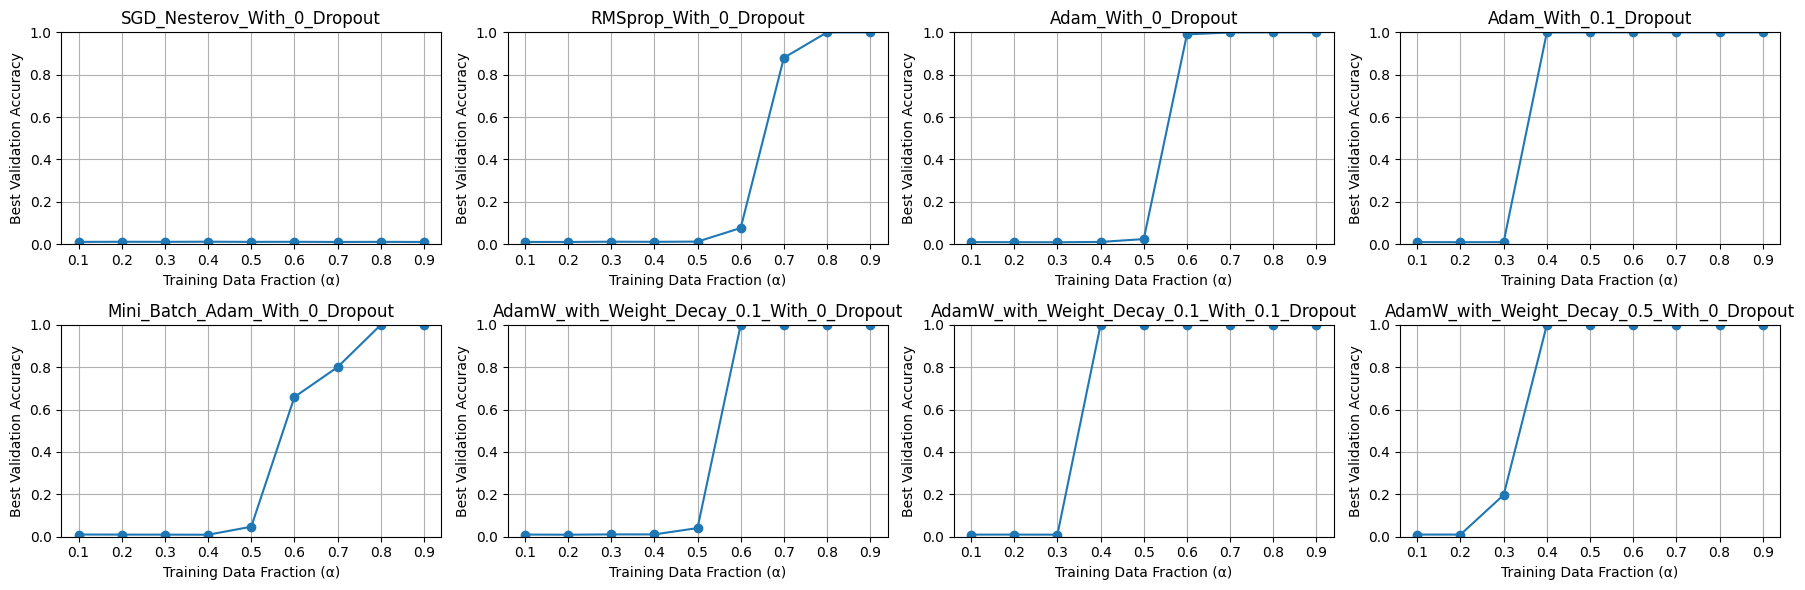

In [24]:
plot_efficiency_curves(results)

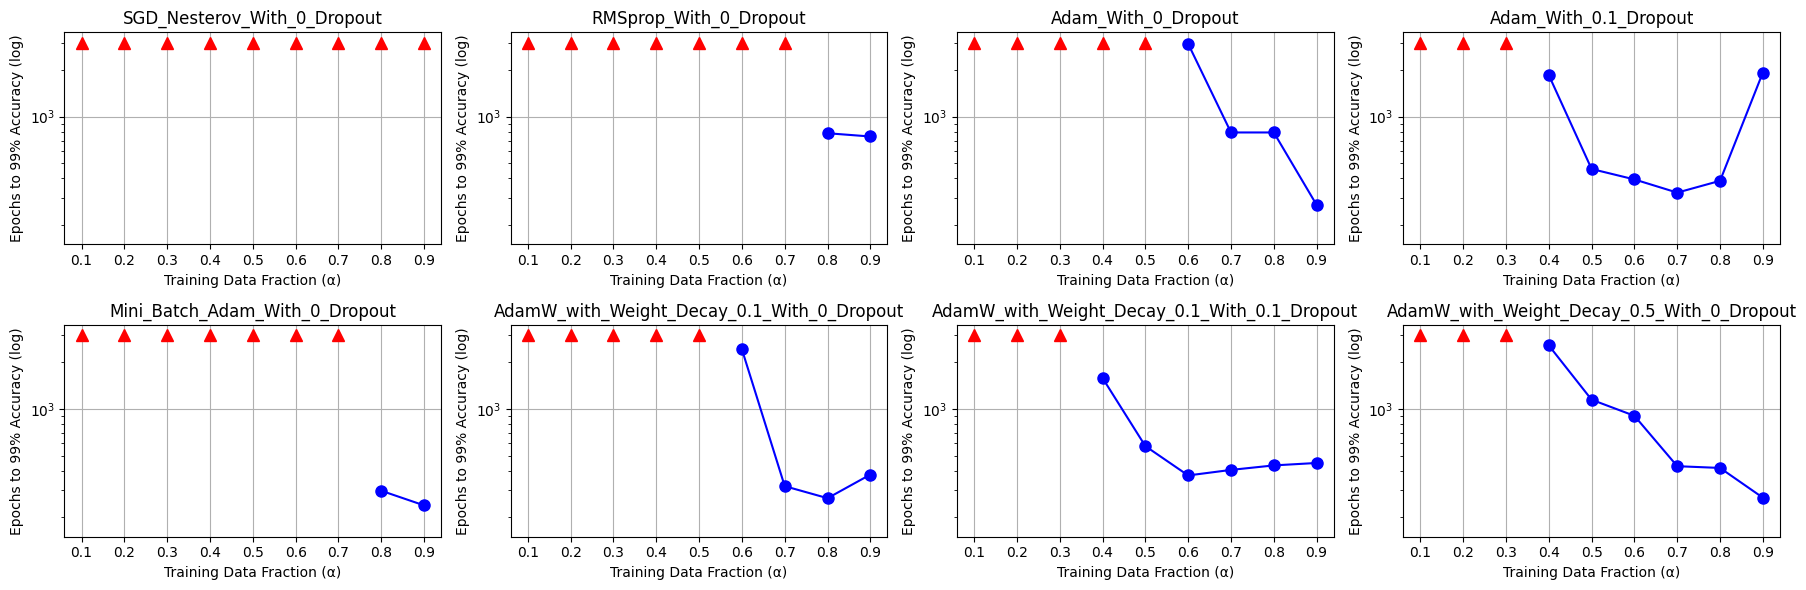

In [39]:
plot_convergence_curves(results)

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_advanced_analysis(results_path='./output/full_results.pkl'):
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    
    def plot_memorization_vs_generalization():
        """Plot gap between train and val accuracy over time"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.ravel()
        
        for idx, (opt_name, data) in enumerate(results.items()):
            for alpha in [0.2, 0.5, 0.8]:
                train = np.array(data[alpha]['train_history'])
                val = np.array(data[alpha]['val_history'])
                gap = train - val
                axes[idx].plot(gap, label=f'α={alpha}')
            
            axes[idx].set_title(opt_name)
            axes[idx].set_xlabel('Epochs')
            axes[idx].set_ylabel('Train-Val Gap')
            axes[idx].grid(True)
            axes[idx].legend()
        
        plt.tight_layout()
        plt.savefig('./output/test/memorization_gap.png')
        plt.close()

    def plot_grokking_phases():
        """Plot learning acceleration points"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        axes = axes.ravel()
        
        for idx, (opt_name, data) in enumerate(results.items()):
            for alpha in [0.2, 0.5, 0.8]:
                val = np.array(data[alpha]['val_history'])
                acceleration = np.gradient(np.gradient(val))
                axes[idx].plot(acceleration, label=f'α={alpha}')
            
            axes[idx].set_title(opt_name)
            axes[idx].set_xlabel('Epochs')
            axes[idx].set_ylabel('Learning Acceleration')
            axes[idx].grid(True)
            axes[idx].legend()
        
        plt.tight_layout()
        plt.savefig('./output/test/grokking_phases.png')
        plt.close()

    def plot_stability_heatmap():
        """Plot training stability across optimizers and alphas"""
        stabilities = []
        opt_names = []
        alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        
        for opt_name, data in results.items():
            row = []
            for alpha in alphas:
                val = np.array(data[alpha]['val_history'])
                stability = np.std(val[-100:])  # Last 100 epochs
                row.append(stability)
            stabilities.append(row)
            opt_names.append(opt_name)
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(stabilities, xticklabels=alphas, yticklabels=opt_names,
                   cmap='viridis', annot=True)
        plt.xlabel('Training Data Fraction (α)')
        plt.ylabel('Optimizer')
        plt.title('Training Stability Analysis')
        plt.savefig('./output/test/stability_heatmap.png')
        plt.close()

    def plot_cross_optimizer_comparison():
        """Compare final performance across optimizers"""
        alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        plt.figure(figsize=(12, 8))
        
        for opt_name, data in results.items():
            final_vals = [data[alpha]['val_history'][-1] for alpha in alphas]
            plt.plot(alphas, final_vals, 'o-', label=opt_name)
        
        plt.xlabel('Training Data Fraction (α)')
        plt.ylabel('Final Validation Accuracy')
        plt.title('Cross-Optimizer Performance Comparison')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.savefig('./output/test/optimizer_comparison.png')
        plt.close()

    # Execute all plots
    plot_memorization_vs_generalization()
    plot_grokking_phases()
    plot_stability_heatmap()
    plot_cross_optimizer_comparison()

# Usage
plot_advanced_analysis()

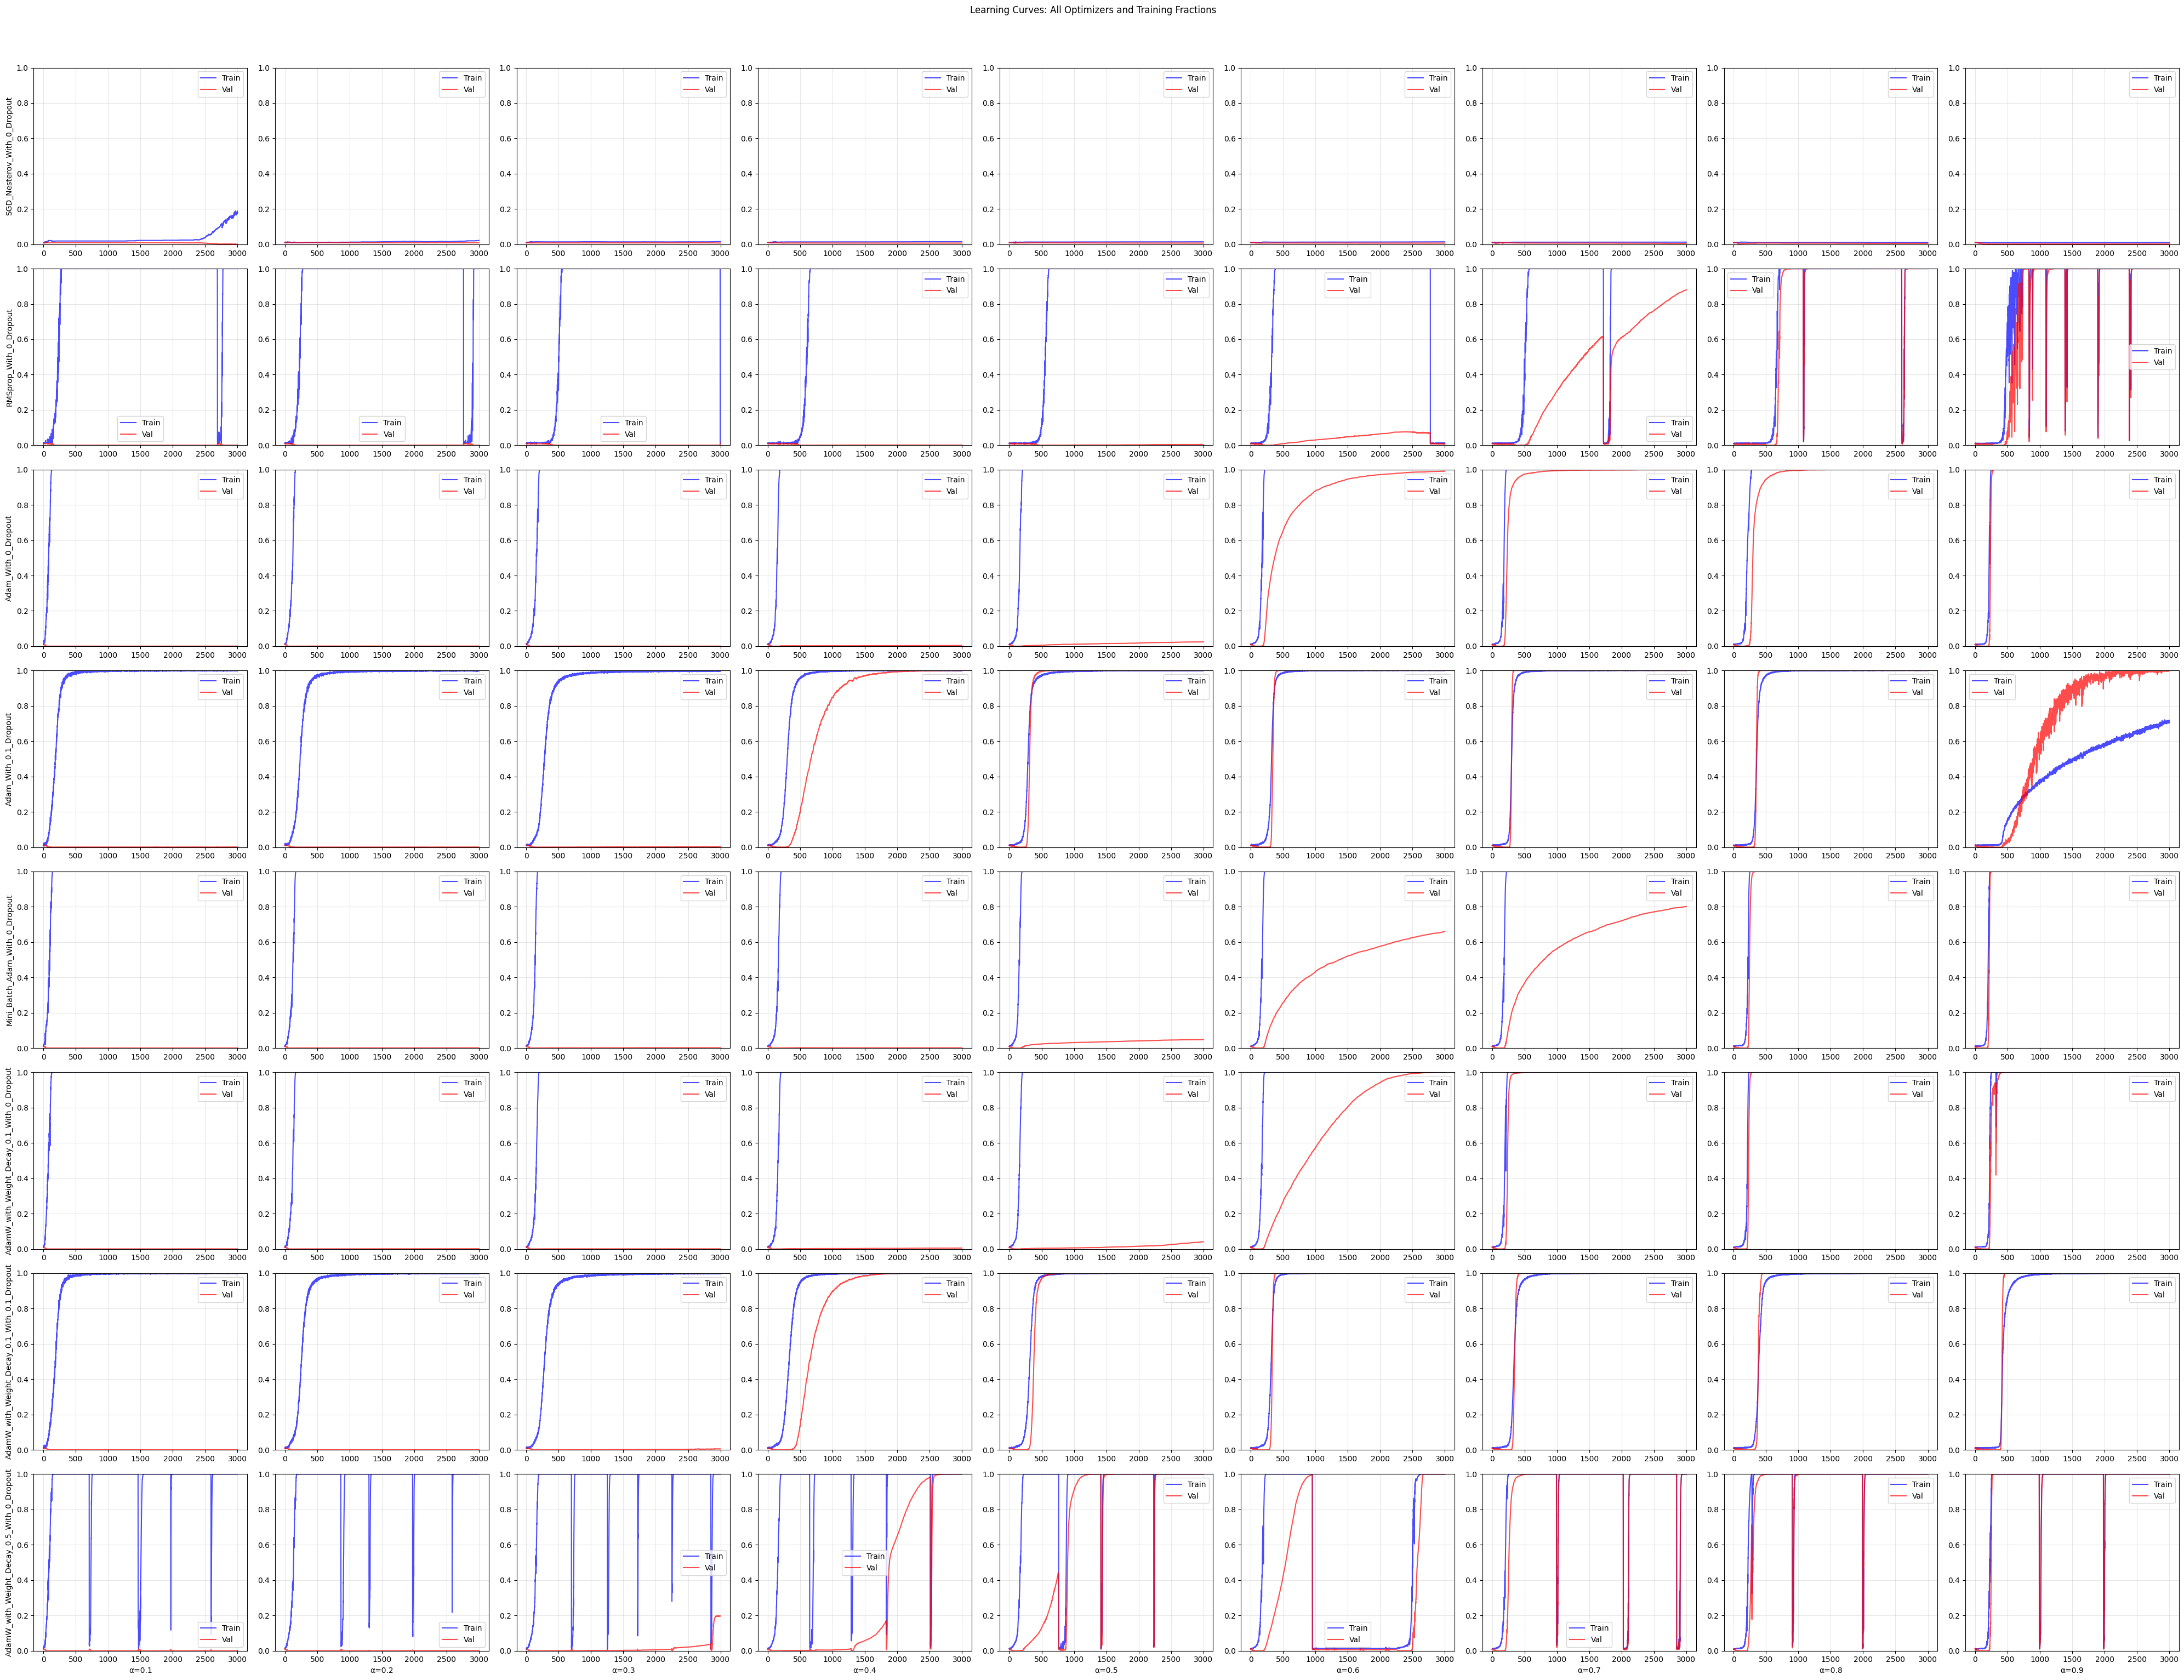

In [40]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

def plot_all_learning_curves(results_path='./output/full_results.pkl'):
    # Load results
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    
    # Create 8x9 subplot grid
    fig, axes = plt.subplots(8, 9, figsize=(40, 30))
    alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    # Plot each optimizer-alpha combination
    for i, (opt_name, opt_data) in enumerate(results.items()):
        for j, alpha in enumerate(alphas):
            ax = axes[i, j]
            
            train_hist = opt_data[alpha]['train_history']
            val_hist = opt_data[alpha]['val_history']
            epochs = range(len(train_hist))
            
            ax.plot(epochs, train_hist, 'b-', label='Train', alpha=0.7)
            ax.plot(epochs, val_hist, 'r-', label='Val', alpha=0.7)
            
            ax.set_ylim(0, 1)
            ax.grid(True, alpha=0.3)
            
            if j == 0:
                ax.set_ylabel(opt_name.split(' With')[0])
            if i == 7:
                ax.set_xlabel(f'α={alpha}')
            
            ax.legend()

    plt.suptitle('Learning Curves: All Optimizers and Training Fractions', y=1.02)
    plt.tight_layout()
    plt.savefig('./output/all_learning_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_all_learning_curves()